Este notebook está corriendo en el ambiente tf_fixed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import shapiro, normaltest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from IPython.display import display


In [ ]:
# 1. Data loading and cleaning
df = pd.read_csv('../data/hourly_electricity.csv', parse_dates=['DateTime'], index_col='DateTime')
df = df.sort_index().interpolate()  # interpolación simple de datos faltantes


In [3]:
df.head(10)

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
2019-01-01 05:00:00,5525,5385,1395,91,958,1455,1456,0,30
2019-01-01 06:00:00,5513,5349,1392,98,938,1451,1440,0,31
2019-01-01 07:00:00,5524,5547,1392,93,1187,1446,1394,0,34
2019-01-01 08:00:00,5510,5471,1391,51,1325,1357,1303,8,34


## Apparently:

Production = Nuclear + Wind + Hydroelectric + Oil and Gas + Coal + Solar + Biomass

Production is therefore an exact linear combination of the other features, which introduces perfect collinearity or redundancy.

✅ Clear recommendation: Check if they are equal. If they are equal, then:

❌ Do NOT include Production as a feature if you already include the individual sources..

In [4]:
# 2. Preprocessing
#  Demonstrate that Production is redundant

df['Production_calc'] = df[['Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass']].sum(axis=1)
df[['Production', 'Production_calc']].head()

#  Check if they are the same
son_iguales = df['Production'].equals(df['Production_calc'])
print(f"¿Production y Production_calc son iguales? {son_iguales}")


¿Production y Production_calc son iguales? False


In [5]:
#  Calculate the average relative difference (avoiding division by zero)
with np.errstate(divide='ignore', invalid='ignore'):
    diferencias_relativas = np.abs((df['Production'] - df['Production_calc']) / df['Production'])
    diferencias_relativas = np.nan_to_num(diferencias_relativas, nan=0.0)  # Manejar divisiones por cero
    mre = diferencias_relativas.mean()

print(f" Average relative difference (MRE): {mre:.6%}")


 Average relative difference (MRE): 0.021319%


In [6]:
# 3. Feature selection excluding 'Production' because it is linearly dependent
features = ['Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'Consumption']

In [7]:
# 4. Preprocessing (data normalization)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), index=df.index, columns=features)


In [8]:
# 5. Creating sequences for LSTM modeling (Sequences from the last 24 hours to predict the next hour)
def create_sequences(data, target_col, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data.iloc[i:i+seq_len].values)
        y.append(data.iloc[i+seq_len][target_col])
    return np.array(X), np.array(y)

SEQ_LEN = 24  
X, y = create_sequences(df_scaled, target_col='Consumption', seq_len=SEQ_LEN)


In [9]:
# 6. Division into Train and Test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# 7. Definition of the LSTM model
# 64 units are chosen in the LSTM layer as a standard starting point that allows the model to capture complex relationships without being overly heavy.
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, len(features)), return_sequences=False),
    Dropout(0.2), #20% dropout to mitigate overfitting.
    Dense(32, activation='relu'), # ReLU prevents the problem of vanishing gradients and speeds up training
    Dense(1)
])
model.compile(optimizer='adam', loss='mse') # Adam is robust and efficient for complex problems

In [11]:
# 8. Training with Early Stopping to avoid overfitting
import time

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

start_time = time.time()  # Start of medition

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)
end_time = time.time()  # End of medition

elapsed_time = end_time - start_time
print(f"⏱️ Total training time: {elapsed_time:.2f} segundos")

Epoch 1/100
735/735 [==============================] - 8s 8ms/step - loss: 0.1172 - val_loss: 0.0289
Epoch 2/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0339 - val_loss: 0.0188
Epoch 3/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0260 - val_loss: 0.0174
Epoch 4/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0226 - val_loss: 0.0145
Epoch 5/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0210 - val_loss: 0.0143
Epoch 6/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0195 - val_loss: 0.0147
Epoch 7/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0187 - val_loss: 0.0165
Epoch 8/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0182 - val_loss: 0.0139
Epoch 9/100
735/735 [==============================] - 6s 7ms/step - loss: 0.0173 - val_loss: 0.0142
Epoch 10/100
735/735 [==============================] - 6s 8ms/step - loss: 0.0170 - val_lo

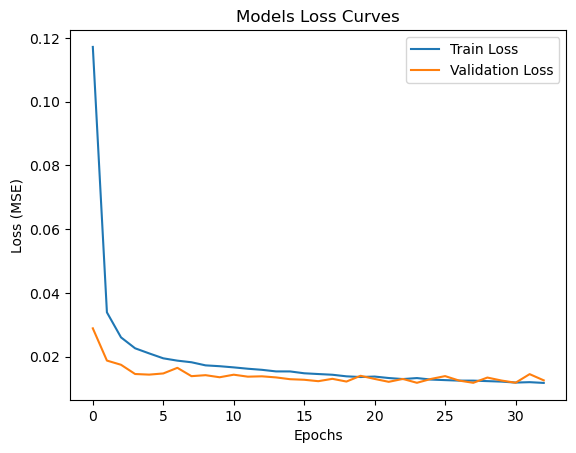

In [12]:
# 9. Visualizing loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Models Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [13]:
# 10. Model evaluation and forecasting
test_loss = model.evaluate(X_test, y_test)
print(f'Test MSE: {test_loss:.4f}')

y_pred = model.predict(X_test)

230/230 [==============================] - 1s 4ms/step - loss: 0.0117
Test MSE: 0.0117
230/230 [==============================] - 1s 3ms/step


In [14]:
# Reverse rescaling to interpret results in original units
# a) Prediction already scaled, we reverse the scaling of 'Consumption' only
# Retrieve the scaler for Consumption
mean_c = scaler.mean_[features.index('Consumption')]
std_c = scaler.scale_[features.index('Consumption')]

# Reverse rescaling (compare in original units)
y_test_rescaled = y_test * std_c + mean_c
y_pred_rescaled = y_pred.flatten() * std_c + mean_c

In [15]:
# b) Calculation of metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

mean_consumption = y_test_rescaled.mean()
mae_percent = (mae / mean_consumption) * 100
rmse_percent = (rmse / mean_consumption) * 100

print(f"Absolute MAE: {mae:.2f} MW ({mae_percent:.2f}%)")
print(f"Absolute RMSE: {rmse:.2f} MW ({rmse_percent:.2f}%)")


Absolute MAE: 83.09 MW (1.33%)
Absolute RMSE: 112.07 MW (1.79%)


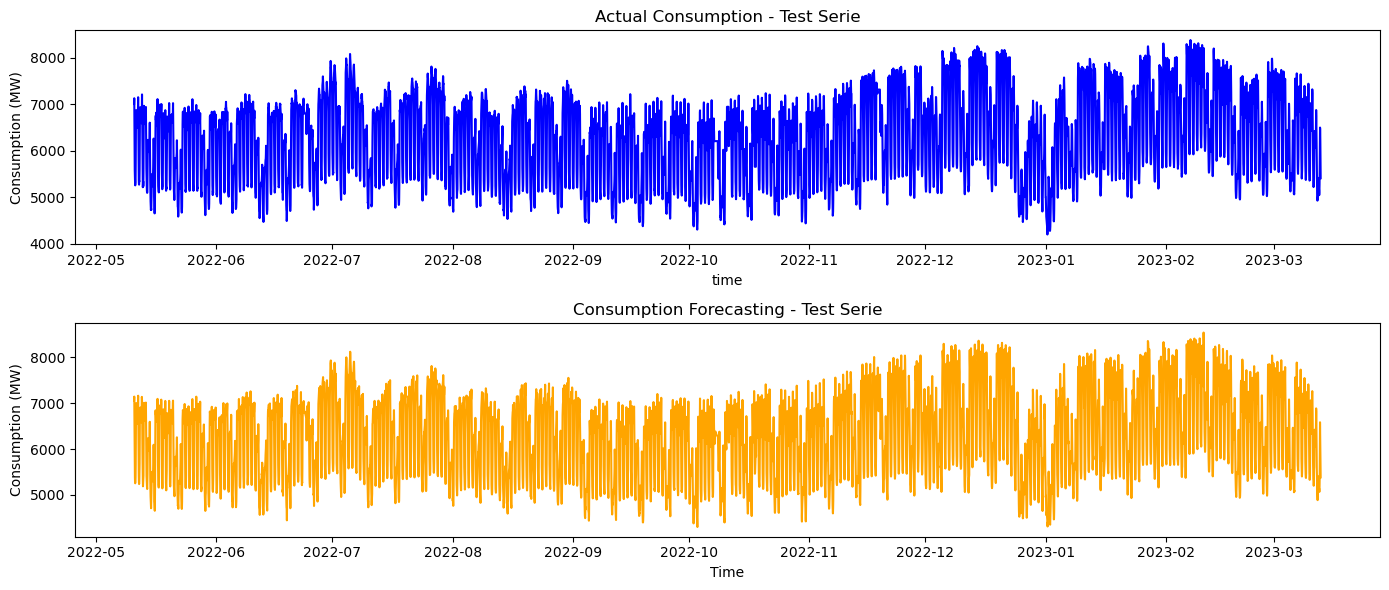

In [16]:
# 11. Professional visualization of results
# Actual time index of the test set

test_index = df_scaled.index[-len(y_test_rescaled):]

plt.figure(figsize=(14,6))

# Graphic 1: Actual Consumption
plt.subplot(2,1,1)
plt.plot(test_index, y_test_rescaled, color='blue')
plt.title('Actual Consumption - Test Serie')
plt.ylabel('Consumption (MW)')
plt.xlabel('time')

# Graphic 2: Forecasting
plt.subplot(2,1,2)
plt.plot(test_index, y_pred_rescaled, color='orange')
plt.title('Consumption Forecasting - Test Serie')
plt.ylabel('Consumption (MW)')
plt.xlabel('Time')

plt.tight_layout()
plt.show()


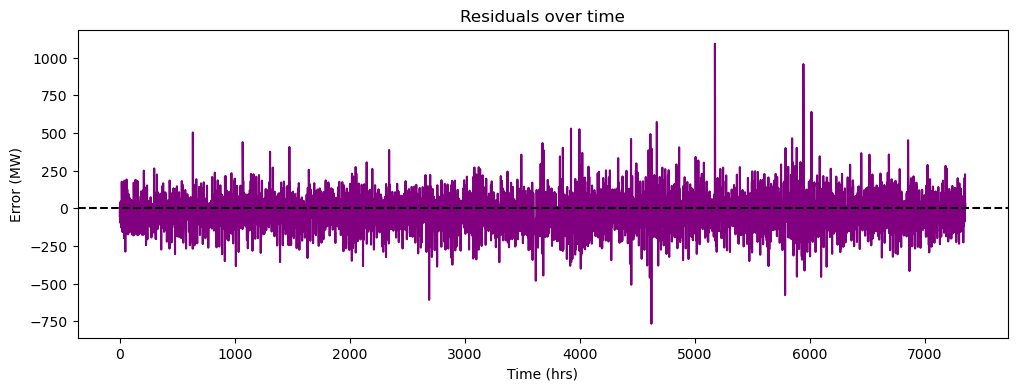

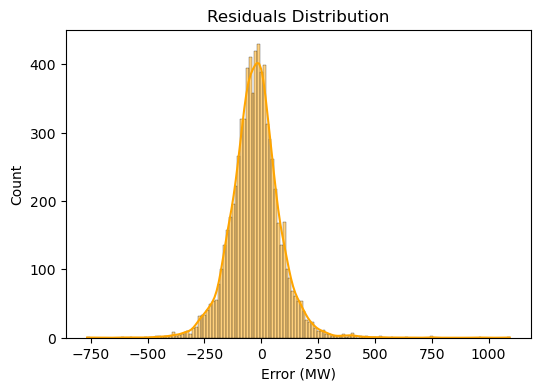

In [17]:
# 12. Residual analysis
residuals = y_test_rescaled - y_pred_rescaled

# Residual temporal serie 
plt.figure(figsize=(12,4))
sns.lineplot(x=np.arange(len(residuals)), y=residuals, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals over time')
plt.xlabel('Time (hrs)')
plt.ylabel('Error (MW)')
plt.show()

# Residual Histogram 
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True, color='orange')
plt.title('Residuals Distribution')
plt.xlabel('Error (MW)')
plt.show()


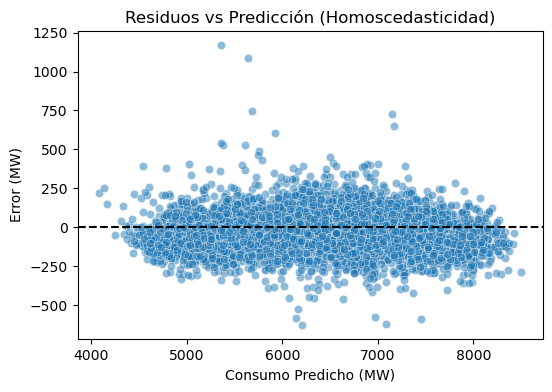

In [38]:
# Análisis de Homoscedasticidad
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_rescaled, y=residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals vs Prediction (Homoscedasticity)')
plt.xlabel('Forecasting (MW)')
plt.ylabel('Error (MW)')
plt.show()


In [18]:
# Statistical tests of residues
shapiro_p = shapiro(residuals)[1]
normaltest_p = normaltest(residuals)[1]
print(f"Test de Shapiro-Wilk p-value: {shapiro_p:.4f}")
print(f"Test de D'Agostino p-value: {normaltest_p:.4f}")


Test de Shapiro-Wilk p-value: 0.0000
Test de D'Agostino p-value: 0.0000


C:\Users\ginzu\anaconda3\envs\tf_forecast\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7350.
  res = hypotest_fun_out(*samples, **kwds)


In [19]:
# 13. Iterative Forecasting
# Interactive forecasting function
def forecast_horizon(horizon_hours=1):
    """
    Produces a consumption forecast for the next 'horizon_hours'.
    Uses chained predictions based on the last known sequence.
    """
    last_sequence = df_scaled[-SEQ_LEN:].values.reshape(1, SEQ_LEN, len(features))
    predictions = []
    sequence = last_sequence.copy()
    
    for _ in range(horizon_hours):
        pred = model.predict(sequence)[0][0]
        predictions.append(pred)
        next_step = np.append(sequence[0, 1:, :], [[*sequence[0, -1, :-1], pred]], axis=0)
        sequence = next_step.reshape(1, SEQ_LEN, len(features))

    # Reverse rescaling of predictions
    mean_c = scaler.mean_[features.index('Consumption')]
    std_c = scaler.scale_[features.index('Consumption')]
    predictions_rescaled = np.array(predictions) * std_c + mean_c

    avg_pred = predictions_rescaled.mean()
    confidence = max(0, 100 - horizon_hours * 2)

    print(f"\n🔮 Average consumption forecast for the next few months {horizon_hours} horas: {avg_pred:.2f} MW")
    print(f"📉 Estimated confidence: {confidence:.1f}% (the longer the horizon, the lower the reliability)")

    plt.figure(figsize=(8,4))
    plt.plot(predictions_rescaled, marker='o', color='orange')
    plt.title(f'Consumption forecast - Next {horizon_hours} hours')
    plt.xlabel('Horizon (hrs)')
    plt.ylabel('Consumption (MW)')
    plt.grid()
    plt.show()

# Activación del widget interactivo
widgets.interact(forecast_horizon, horizon_hours=widgets.IntSlider(value=1, min=1, max=24, step=1, description='Horizon (h)'));


interactive(children=(IntSlider(value=1, description='Horizon (h)', max=24, min=1), Output()), _dom_classes=('…

In [20]:
# 14.Mostrar resumen estructural del modelo
model.summary()

# Extraer pesos de cada capa
for i, layer in enumerate(model.layers):
    print(f"\n🔧 Capa {i} - {layer.name}")
    weights = layer.get_weights()
    for j, param in enumerate(weights):
        print(f"  Parámetro {j} - Forma: {param.shape}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 20801 (81.25 KB)
Trainable params: 20801 (81.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

🔧 Capa 0 - lstm
  Parámetro 0 - Forma: (8, 256)
  Parámetro 1 - Forma: (64, 256)
  Parámetro 2 - Forma: (256,)

🔧 Capa 1 - dropout

🔧 Capa 2 - dense
  